In [247]:
%matplotlib inline
import pandas as pd
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.query_api import QueryApi
import matplotlib.pyplot as plt
import numpy as np

In [248]:
token = 'MlUmh8wWKDAcBiZbBjvJPguGKxoON1ZRqFjVQ_zh8M3NHLcr53WnxbfXX_ByD0Wm7S8G0kb622gj2EX25MzFCA=='
org = "Portfolio_Opt"
url = "http://localhost:8080"
bucket = "Nifty50"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()

In [249]:
symbols = ['ASIANPAINT.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'INFY.NS', 'TCS.NS', 'TECHM.NS']

start_date = '2017-01-01'
end_date = '2022-01-01'

all_data = pd.DataFrame()

In [250]:
for symbol in symbols:
    # Construct the Flux query
    query = f'''
    from(bucket: "{bucket}")
      |> range(start: {start_date}, stop: {end_date})
      |> filter(fn: (r) => r["_measurement"] == "market_data")
      |> filter(fn: (r) => r["_field"] == "close")
      |> filter(fn: (r) => r["symbol"] == "{symbol}")
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    '''
    # Execute the query
    result = query_api.query_data_frame(query=query)
    if not result.empty:
        result.set_index('_time', inplace=True)
        result = result[['close']]  # Ensure only close data is used
        result.columns = [symbol]  # Rename column to symbol name

        if all_data.empty:
            all_data = result
        else:
            all_data = all_data.join(result, how='outer')

print(all_data)

# Save the consolidated data to CSV
all_data.to_csv('training_data.csv')

                           ASIANPAINT.NS  BAJAJ-AUTO.NS  BAJFINANCE.NS  \
_time                                                                    
2017-01-02 00:00:00+00:00     904.650024    2598.500000     870.049988   
2017-01-03 00:00:00+00:00     896.599976    2619.199951     884.000000   
2017-01-04 00:00:00+00:00     906.599976    2684.100098     871.900024   
2017-01-05 00:00:00+00:00     916.500000    2723.350098     899.750000   
2017-01-06 00:00:00+00:00     929.500000    2707.350098     878.450012   
...                                  ...            ...            ...   
2021-12-27 00:00:00+00:00    3272.399902    3154.100098    6890.750000   
2021-12-28 00:00:00+00:00    3368.199951    3176.050049    6906.649902   
2021-12-29 00:00:00+00:00    3367.449951    3262.500000    6911.649902   
2021-12-30 00:00:00+00:00    3365.699951    3200.800049    6871.100098   
2021-12-31 00:00:00+00:00    3382.949951    3249.250000    6977.299805   

                            HCLTECH.N

In [251]:

# Calculate log returns for all stocks
log_returns = np.log(all_data / all_data.shift(1))

# Define rolling window for volatility calculation
rolling_window_days = 21
volatility = log_returns.rolling(window=rolling_window_days).std() * np.sqrt(252)


In [252]:
# Initialize parameters
T = 1  # Time period
n_time_intervals = 365  # Number of time intervals
n_simulations = 20
delta_t = T / n_time_intervals


Stock price forecast for ASIANPAINT.NS: 2.54%
Stock price forecast for BAJAJ-AUTO.NS: 8.07%
Stock price forecast for BAJFINANCE.NS: 3.59%
Stock price forecast for HCLTECH.NS: 3.70%
Stock price forecast for INFY.NS: 5.58%
Stock price forecast for TCS.NS: 9.11%
Stock price forecast for TECHM.NS: 12.56%


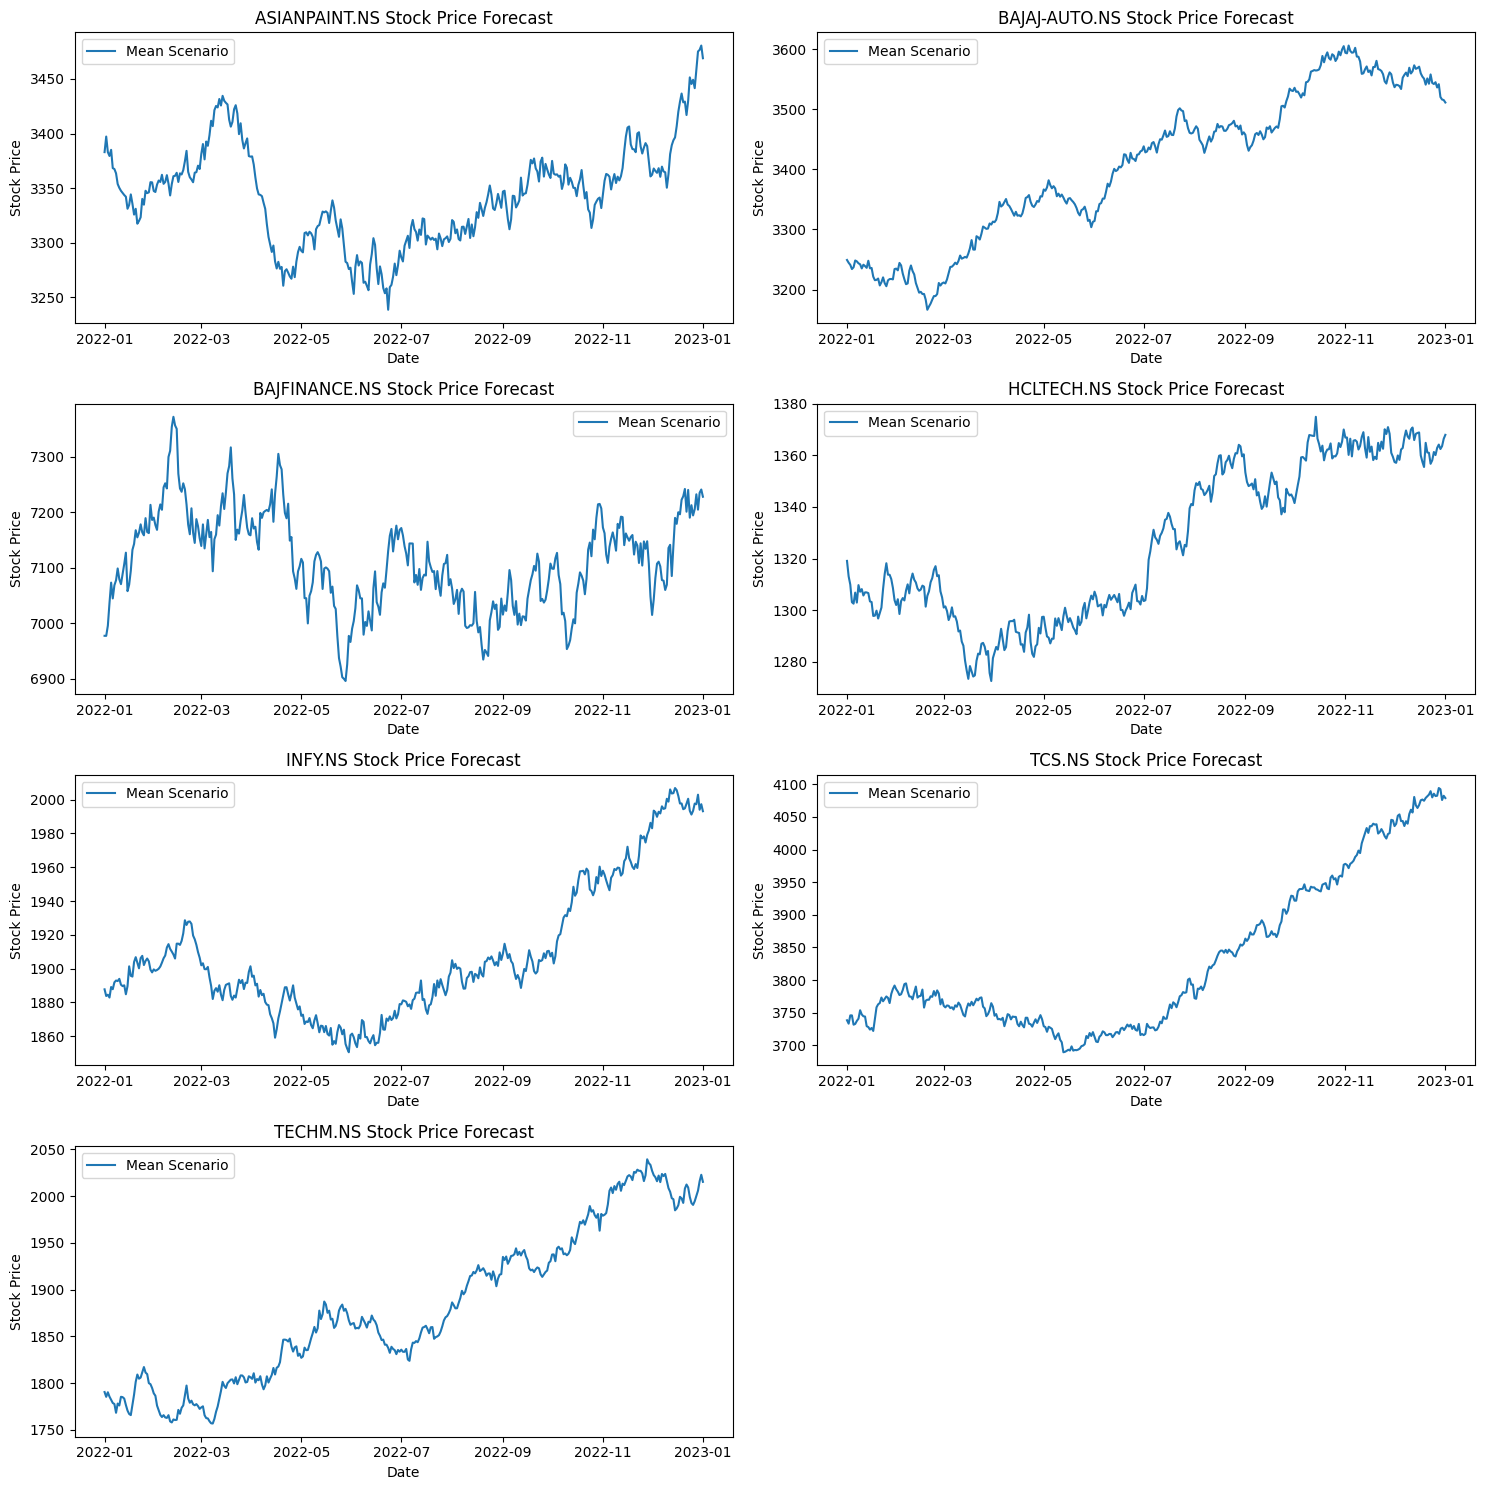

In [253]:
predicted_data = pd.DataFrame(index=pd.date_range(start=end_date, periods=n_time_intervals+1, freq='D'))

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, symbol in enumerate(symbols):
    S0 = all_data[symbol].iloc[-1]  # Most recent stock price
    vol = volatility[symbol].iloc[-1]  # Most recent volatility
    rf = 0.06971  # Assuming a risk-free rate of 6.971%

    # Initialize stock price array
    S_fwd = np.zeros((n_time_intervals + 1, n_simulations))
    S_fwd[0] = S0

    # Run the simulation
    for t in range(1, n_time_intervals + 1):
        S_fwd[t] = S_fwd[t - 1] * np.exp((rf - 0.5 * vol**2) * delta_t + vol * np.sqrt(delta_t) * np.random.standard_normal(n_simulations))

    # mean_scenario = S_fwd.mean(axis=1)
    mean_scenario = S_fwd.mean(axis=1)
    predicted_data[symbol] = mean_scenario

    # Calculate forecast percentage based on the mean scenario
    delta_stock_price = (mean_scenario[-1] - S0) / S0
    delta_stock_price_percentage = "{:.2%}".format(delta_stock_price)
    print(f"Stock price forecast for {symbol}: {delta_stock_price_percentage}")

    forecast_dates = pd.date_range(start=end_date, periods=n_time_intervals+1, freq='D')

   # Plot the forecasted mean scenario
    axes[i].plot(predicted_data.index, mean_scenario, label='Mean Scenario')
    axes[i].set_title(f"{symbol} Stock Price Forecast")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Stock Price")
    axes[i].legend()

# Handle empty subplot (if any)
if len(symbols) < 8:
    for j in range(len(symbols), 8):
        fig.delaxes(axes[j])

# Adjust layout and show plots
plt.tight_layout()
plt.show()